## TODO
 - Zindhi discussions
 - Model with voting
 - Model with stacking
 - Different model types
 - Under+Upper sampling together
 - baseline model: Only over-consumption

In [1]:
from sklearn.metrics import recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")

N_JOBS= 8
RSEED = 12345
PRIMARY_SCORE = "f1"
COUNTER_TYPE_MAPPING = {"ELEC": 0, "GAZ": 1}
MAX_FEATURES_PER_ROW = 6
TARGET_LABELS = {0: "Regular", 1: "Fraud"}
COLUMNS_ONE_HOT_ENCODING = [
    "disrict", 
    "region", 
    "client_catg", 
    "tarif_type", 
    "reading_remarque",
	"counter_type", 
    "counter_code", 
    "counter_statue", 
    "counter_coefficient"
]


def evaluate_model(y_true, y_predict, y_predict_proba):
    print(f"F1: {f1_score(y_true, y_predict):.2f}")
    print(f"Recall: {recall_score(y_true, y_predict):.2f}")
    print(f"TNR: {recall_score(y_true, y_predict, pos_label=0):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_predict_proba):.2f}")
    print(confusion_matrix(y_true, y_predict))


def train_and_predict(classifier, X_train, y_train, X_test, y_test, scaler=None):
    if scaler is not None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    classifier.fit(X_train, y_train)
    print("[TRAIN]")
    evaluate_model(y_train, classifier.predict(X_train), classifier.predict_proba(X_train)[:,1])
    print("\n[TEST]")
    evaluate_model(y_test, classifier.predict(X_test), classifier.predict_proba(X_test)[:,1])


def feature_importance(tree, feature_names):
    fig, ax = plt.subplots()
    pd.Series(tree.feature_importances_, index=feature_names).plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [24]:
df_clients = pd.read_csv("data/train/client_train.csv")

# Convert target from float to int
df_clients["target"] = df_clients["target"].astype(int)

# Derive fe4atures from creation date
creation_date = pd.to_datetime(df_clients["creation_date"], format="%d/%m/%Y")
df_clients["creation_date"] = creation_date
df_clients["creation_day"] = creation_date.dt.strftime("%Y%m%d").astype(int)
df_clients["creation_year"] = creation_date.dt.year
df_clients["creation_month"] = creation_date.dt.strftime("%Y%m").astype(int)


df_invoices = pd.read_csv("data/train/invoice_train.csv")

# Sanitize counter type and status
df_invoices["counter_type"] = df_invoices["counter_type"].map(COUNTER_TYPE_MAPPING).astype(int)
df_invoices["counter_statue"] = df_invoices["counter_statue"].replace("A", 10).astype(int)

# Also derive sum of all consommations
#df_invoices["consumption"] = df_invoices["new_index"] - df_invoices["old_index"]

# Derive parts from invoice date
invoice_date = pd.to_datetime(df_invoices["invoice_date"], format="%Y-%m-%d")
df_invoices["invoice_date"] = invoice_date
df_invoices["invoice_day"] = invoice_date.dt.strftime("%Y%m%d").astype(int)
df_invoices["invoice_year"] = invoice_date.dt.year
df_invoices["invoice_month"] = invoice_date.dt.strftime("%Y%m").astype(int)


In [25]:
df = df_invoices.merge(df_clients, on="client_id")
"""
df_y = df[df["target"] == 0] \
    .groupby("invoice_year") \
    .agg(consumption_mean=("consumption", "mean"), consumption_std=("consumption", "std")) \
    .reset_index()

df = df.merge(df_y, on="invoice_year")
df["over_consumption"] = df["consumption"] - df["consumption_mean"]
"""

'\ndf_y = df[df["target"] == 0]     .groupby("invoice_year")     .agg(consumption_mean=("consumption", "mean"), consumption_std=("consumption", "std"))     .reset_index()\n\ndf = df.merge(df_y, on="invoice_year")\ndf["over_consumption"] = df["consumption"] - df["consumption_mean"]\n'

In [26]:
df = df[(invoice_date.dt.year >= 2005) & (df["counter_statue"] <= 5)]

,target,days
0,0,8844
1,0,6152
2,0,12103
3,0,5920
4,0,1707
...,...,...
135488,0,5448
135489,0,2427
135490,0,2906
135491,0,4380


5138.862390269451
6869.594898228919


<Axes: xlabel='days', ylabel='Count'>

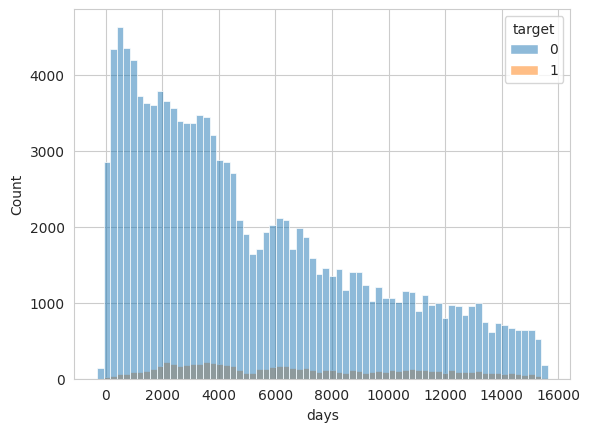

In [46]:
dfx = df_clients[["client_id", "creation_date", "target"]]
dfy = df_invoices.groupby("client_id").agg(last_invoice=("invoice_date", "max")).reset_index()
dfz = dfx.merge(dfy, on="client_id")
dfz["days"] = (dfz["last_invoice"] - dfz["creation_date"]).dt.days
dfz.drop(["client_id", "creation_date", "last_invoice"], axis=1, inplace=True)
display(dfz)

print(dfz[dfz["target"] == 0]["days"].mean())
print(dfz[dfz["target"] == 1]["days"].mean())

sns.histplot(dfz, x="days", hue="target")

[TRAIN]
F1: 0.00
Recall: 0.00
TNR: 1.00
ROC-AUC: 0.67
[[89549     0]
 [ 5296     0]]

[TEST]
F1: 0.00
Recall: 0.00
TNR: 1.00
ROC-AUC: 0.61
[[38378     0]
 [ 2270     0]]


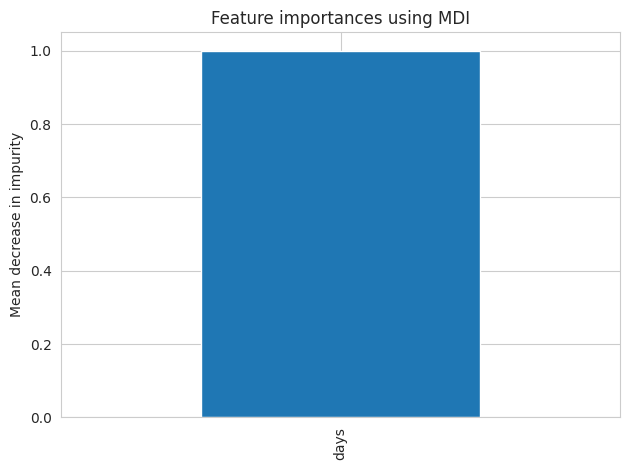

In [41]:
y = dfz["target"]
X = dfz.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = RSEED)

classifier = DecisionTreeClassifier(random_state=RSEED)
train_and_predict(classifier, X_train, y_train, X_test, y_test)
feature_importance(classifier, X.columns)

In [28]:
df = df.drop(
    [
        "client_id", "months_number", "counter_number",
        "consommation_level_1", "consommation_level_2", "consommation_level_3", "consommation_level_4",
        "invoice_date", "creation_date"
    ], axis=1
)

In [29]:
#df = pd.get_dummies(drop_first=True, data=df, columns=COLUMNS_ONE_HOT_ENCODING)

In [30]:
y = df["target"]
X = df.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = RSEED)

[TRAIN]
F1: 1.00
Recall: 0.99
TNR: 1.00
ROC-AUC: 1.00
[[2870941      94]
 [   1696  245482]]

[TEST]
F1: 0.65
Recall: 0.65
TNR: 0.97
ROC-AUC: 0.81
[[1193239   37205]
 [  36706   69228]]


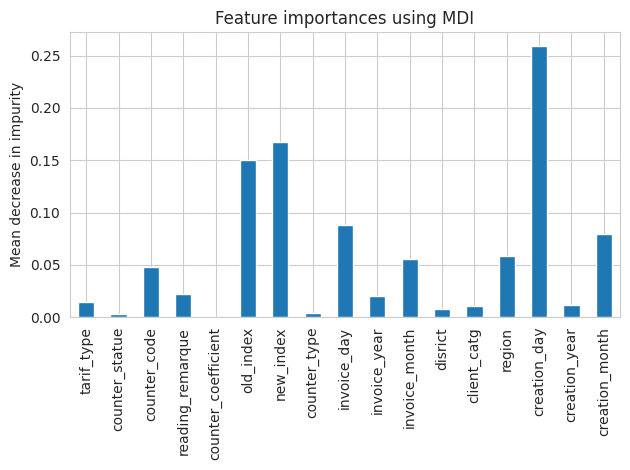

In [31]:
classifier = DecisionTreeClassifier(random_state=RSEED)
train_and_predict(classifier, X_train, y_train, X_test, y_test)
feature_importance(classifier, X.columns)